In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
from math import radians, cos, sin, asin, sqrt

from matplotlib import pyplot as plt

In [64]:
data = pd.read_csv('taxi.csv')
data.head(5)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [8]:
data.describe

<bound method NDFrame.describe of        offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
0       1105373            5        20       6080    174182        55.818842   
1        759733            5        14       6080    358774        55.805342   
2        416977            6        14       6080    866260        55.813978   
3        889660            2         6       6080    163522        55.745922   
4       1120055            4        16       6080    506710        55.803578   
...         ...          ...       ...        ...       ...              ...   
99995    726210            0         2       2442     27360        55.961246   
99996    881472            0         1       2442    381960        55.961246   
99997    626673            1        20       2442    627126        55.961315   
99998    672584            6        21       2442    140623        55.961354   
99999    542637            0        23       2442    140050        55.961364   

     

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


1. Координаты сложно использовать - пока не решили как 
2. Расстояние значимое моле  - значимое поле - нужно првоерить на нулевые элементы 
3. Продолжительность - значимое поле - нужно проверить на нулевые элементы
4. Имеем продожлительность и расстояние - возможно средняя скорость понадобиться 
5. offer_class_group	нужно проверить как распределяются значения и закодировать 
6. offer_class_group	 проверить как распределяются значнеия и закодировать 
7. driver_response флаг да нет - отклика

In [65]:
# есть много аномалий - отрицательное расстояние и время
data[data['distance_km']<1]
def haversine(data):
    km = data['distance_km']
    if (data['distance_km']<1):
        lon1, lat1, lon2, lat2 = map(radians, (data['driver_longitude'], data['driver_latitude'], data['origin_order_longitude'], data['origin_order_latitude']))
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        km = 6367 * c
    return km
# Выставим расстояние в км как расстояние между координтами
data['distance_km'] = data.apply(haversine, axis=1)


In [66]:
# избавляемся из аномалии время -1 и 0 пробивая количество минут исходя из расстояния  и скорости 60км.ч
# в это случае продолжительность пути совпадает с дистанцией в км потому что 1 км/мин
data['duration_min'] = data.apply(lambda x:x['distance_km'] if x['duration_min']<1 else x['duration_min'] , axis=1) 
data[data['duration_min']<1].head(10)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,0.647066,0.647066,Economy,private,1
6,103326,2,11,6080,615584,55.753508,37.663742,55.757251,37.659064,0.508509,0.508509,Standard,business,1
19,533917,5,8,6080,596531,55.913718,37.401395,55.921554,37.403505,0.880634,0.880634,Standard,business,0
21,123897,4,12,6080,185909,55.766763,37.607275,55.772388,37.606330,0.627864,0.627864,Standard,business,0
31,275040,4,7,6080,290066,55.913695,37.402437,55.906912,37.400428,0.764077,0.764077,Economy,private,0
37,271945,6,16,6080,50600,55.754892,37.403615,55.746143,37.405168,0.977073,0.977073,Standard,private,1
44,418105,1,11,6080,448477,55.778212,37.621583,55.785984,37.625511,0.897868,0.897868,Standard,business,1
55,1004363,1,9,6080,805454,55.779773,37.644112,55.777440,37.654330,0.689203,0.689203,Standard,private,1
64,995595,1,7,6080,567900,55.786522,37.570957,55.788417,37.557689,0.855335,0.855335,Standard,private,1
77,1093080,6,11,6080,830494,55.781892,37.663638,55.787733,37.673168,0.880861,0.880861,Standard,business,1


In [44]:
pandas_profiling.ProfileReport(data)

D:\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,14
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,10.7 MiB
Average record size in memory,112.0 B
Numeric,9
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,2


Выводы по корреляции
Нет кареляции по показателям _gk - это справочные данные и индексы - можно удалять
После использования координат для заполнения неадекватных данных по расстояниям - можем удалить эти колонки
Предварительно необходимо отсмотреть выборосы по времени и расстоянию
Отсмотрим значения по классификационным параметрам поездки для оценки после

In [67]:
data.drop(['driver_gk', 'order_gk', 'offer_gk'], axis=1, inplace=True)

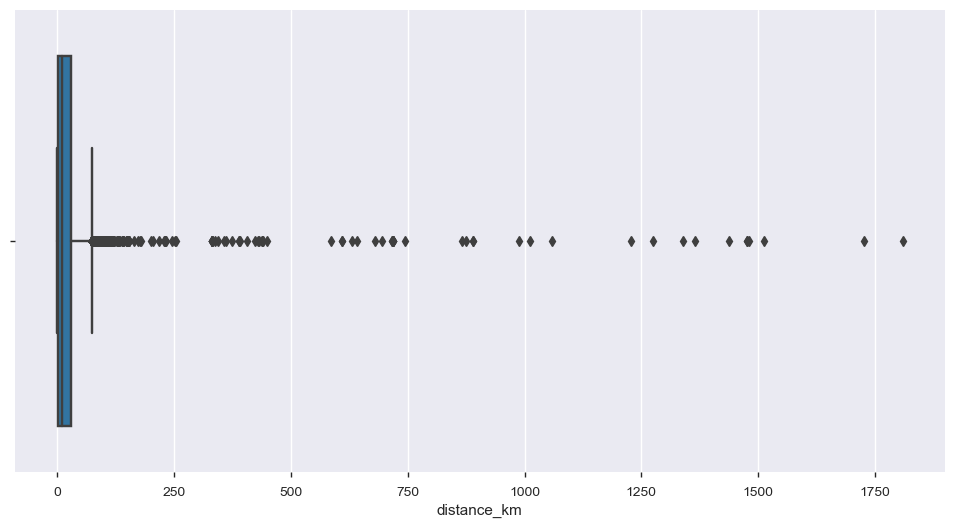

In [73]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['distance_km'])

Есть значительные выборосы по расстоянию - возможно это ошибки GPS

In [80]:
# Рассматриваем выбросы по условиям
#data[data['distance_km']>2000]
#data[(data['distance_km']>2000) & (data['driver_latitude']>0)]
#data[data['distance_km']>500].shape # Таких поездок всего 33 - возможно есть смысл удалить
#data[data['distance_km']>250].shape # Таких поездок всего 58 - возможно есть смысл удалить все
data[data['distance_km']>100].shape # Таких поездок всего 170 - возможно есть смысл удалить все

(170, 11)

Видим, что по большей части выбросы по расстоянию связаны с неадекватным определением координат водителя - возможно ошибка GPS устройства
Таких строк суммарно 129 - есть несколько маршрутов, где данные координат определены корректно, но их мало и желательно удалить как выброси

In [71]:
# удаляем выбросы с ошибочными координатами
data = data[~(data['distance_km']>2000)]

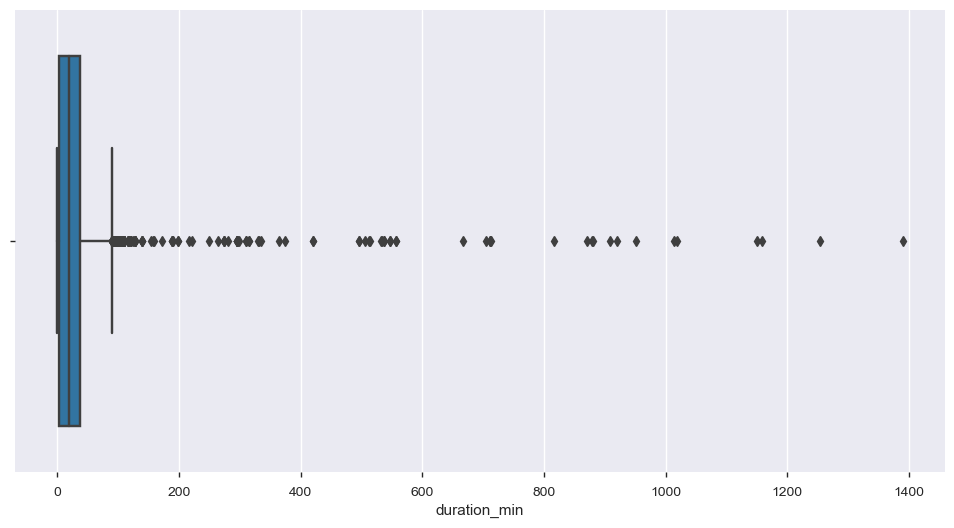

In [81]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['duration_min'])

In [89]:
# Рассматриваем выбросы по условиям
data[data['duration_min']>600].shape # Таких поездок всего 18 - возможно есть смысл удалить
#data[data['duration_min']>400].shape # Таких поездок всего 33 - возможно есть смысл удалить
#data[data['duration_min']>200].shape # Таких поездок всего 58 - возможно есть смысл удалить все
#data[data['duration_min']>100].shape # Таких поездок всего 123 - возможно есть смысл удалить все

(18, 11)

Сохраним вариант с удалением для сравнения

In [108]:
# чистим выбросы по координатам дополнительно 
#plt.figure(figsize=(12,6))
#sns.boxplot(x=data_cl1['driver_latitude'])
data[data['origin_order_longitude']<1].shape # 19 записей с 0 координатой
#data = data[~(data['driver_latitude']<1)]
#data = data[~(data['origin_order_latitude']<1)]


(0, 11)

In [109]:
# Можем удалить поля с координатами
data.drop(['driver_latitude','driver_longitude','origin_order_latitude','origin_order_longitude'], axis=1, inplace=True)

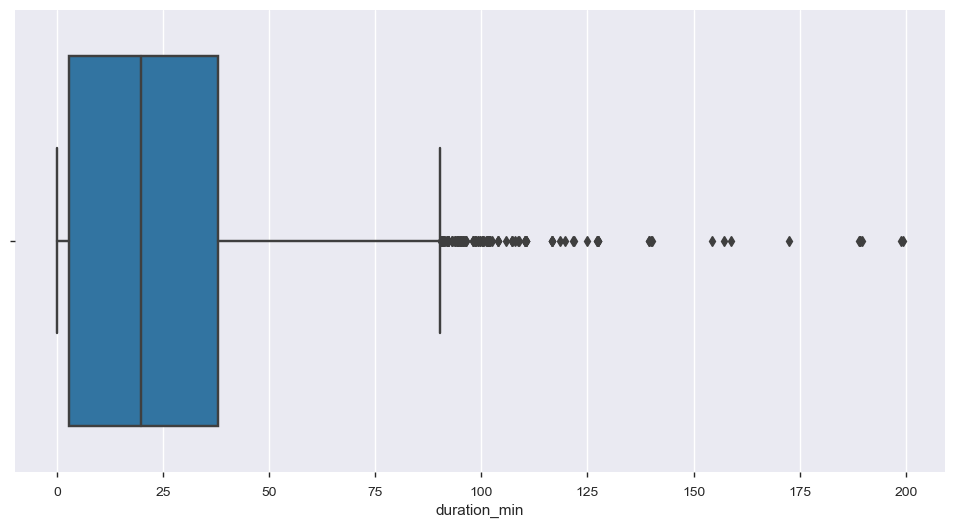

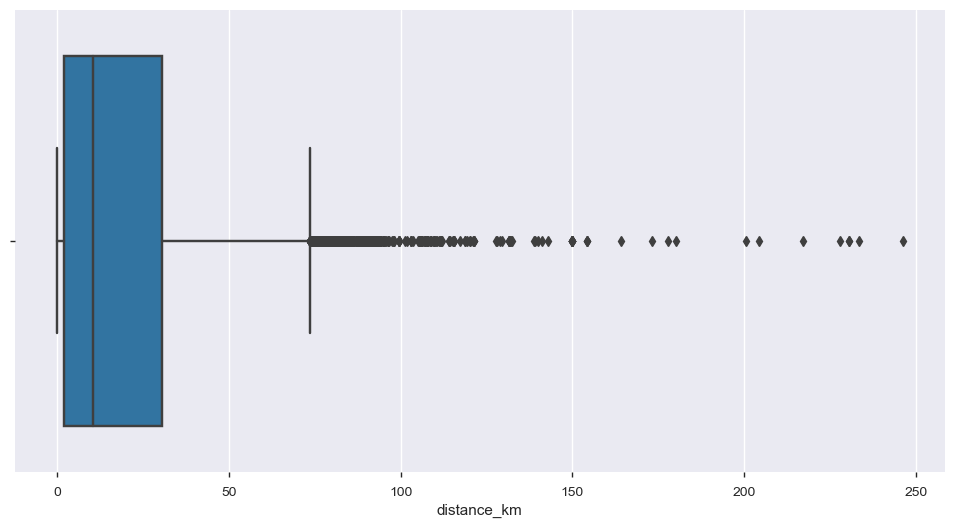

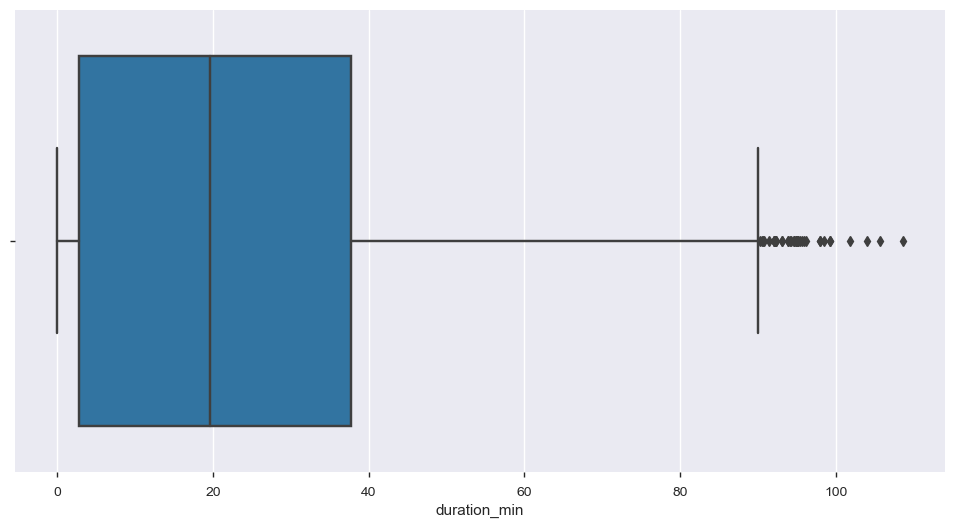

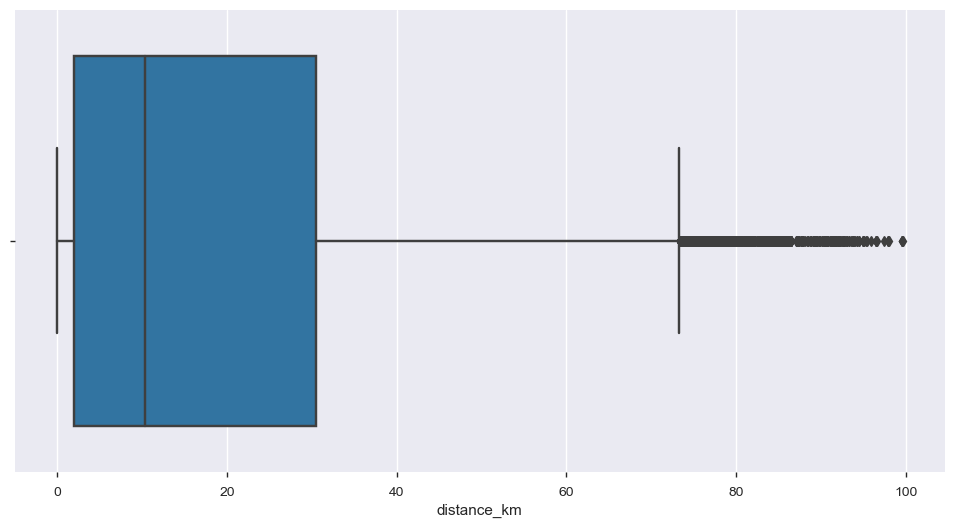

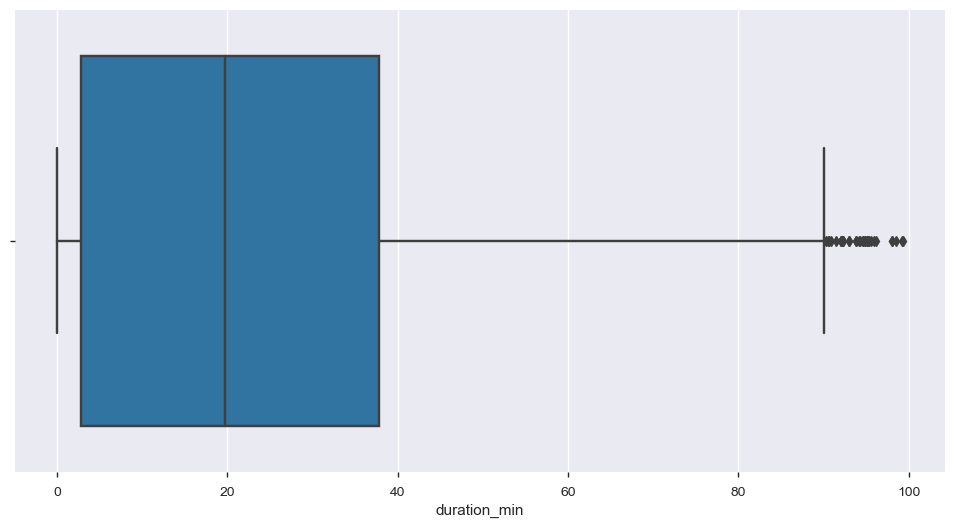

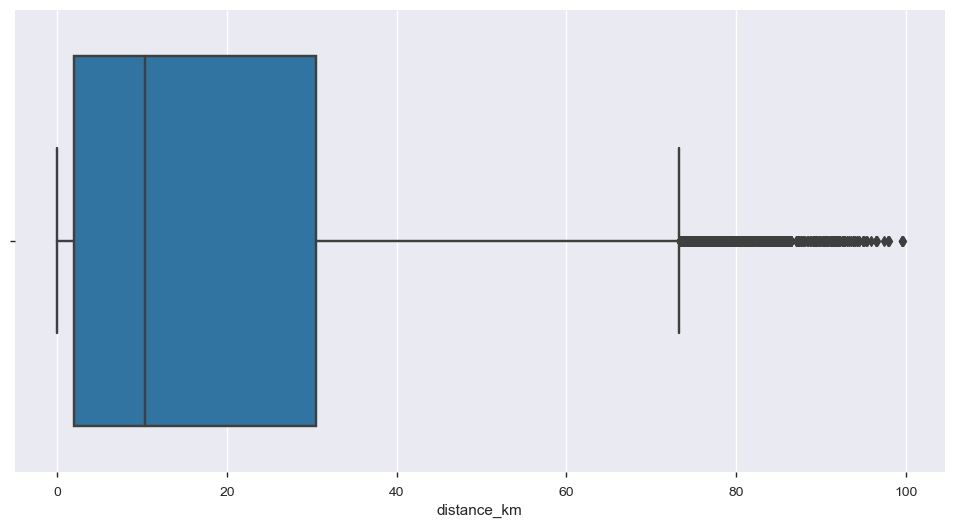

In [110]:
data_cl1 = data[~(data['duration_min']>200)]
plt.figure(figsize=(12,6))
sns.boxplot(x=data_cl1['duration_min'])
plt.figure(figsize=(12,6))
sns.boxplot(x=data_cl1['distance_km'])
# для сравнения вторая база с чисткой большего количество выбросов
data_cl2 = data[~(data['distance_km']>100)]
plt.figure(figsize=(12,6))
sns.boxplot(x=data_cl2['duration_min'])
plt.figure(figsize=(12,6))
sns.boxplot(x=data_cl2['distance_km'])
# для сравнения вторая база с чисткой большего количество выбросов
data_cl3 = data_cl2[~(data_cl2['duration_min']>100)]
plt.figure(figsize=(12,6))
sns.boxplot(x=data_cl3['duration_min'])
plt.figure(figsize=(12,6))
sns.boxplot(x=data_cl3['distance_km'])

In [111]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
# применим ColumnTransformer что бы сделать сразу одной строкой преобразование без label
from sklearn.compose import ColumnTransformer
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), ['offer_class_group','ride_type_desc'])], remainder='passthrough')
data_hot1 = pd.DataFrame(columnTransformer.fit_transform(data))

In [112]:
data_hot1.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,20.0,1.362189,1.362189,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,14.0,18.802000,25.217000,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,14.0,6.747000,9.800000,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,6.0,0.647066,0.647066,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,16.0,12.383000,19.250000,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,6.747000,9.800000,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,11.0,0.508509,0.508509,1.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,20.0,1.517000,3.933000,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,20.0,6.222000,15.433000,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,7.0,10.410000,23.083000,0.0


In [113]:
pandas_profiling.ProfileReport(data_hot1)

D:\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,18
Number of observations,99841
Total Missing (%),0.0%
Total size in memory,13.7 MiB
Average record size in memory,144.0 B
Numeric,3
Categorical,0
Boolean,14
Date,0
Text (Unique),0
Rejected,1


In [114]:
# разбиваем на тестовые и тренировочные
# Выделим из датасета тренировочные и тестовые данные. 
# Тренировочные данные будем использовать для обучения модели. 
# Тестовые данные будем использовать для подсчета качества модели.
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X, y = data_hot1.drop([17], axis=1), data_hot1[17]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


In [115]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [116]:
from sklearn.metrics import classification_report
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

model.score(X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.70      0.68      0.69     15157
         1.0       0.68      0.70      0.69     14796

    accuracy                           0.69     29953
   macro avg       0.69      0.69      0.69     29953
weighted avg       0.69      0.69      0.69     29953



0.6912496244115781

Модель "рандомных деревьев" дала точность предсказания порядка 69%.

In [117]:
# провеверям влияет ли дополнительная чистка выбрасов на качество модели
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), ['offer_class_group','ride_type_desc'])], remainder='passthrough')
data_hot3 = pd.DataFrame(columnTransformer.fit_transform(data_cl3))

In [118]:
X_cl3, y_cl3 = data_hot3.drop([17], axis=1), data_hot3[17]

X_cl3_train, X_cl3_test, y_cl3_train, y_cl3_test = train_test_split(X_cl3, y_cl3, test_size = 0.3, random_state = 0)

In [119]:
model=RandomForestClassifier(n_estimators=100)
model.fit(X_cl3_train, y_cl3_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [120]:
model_pred = model.predict(X_cl3_test)

print(classification_report(y_cl3_test, model_pred))

model.score(X_cl3_test, y_cl3_test)

              precision    recall  f1-score   support

         0.0       0.70      0.69      0.70     15171
         1.0       0.69      0.70      0.69     14730

    accuracy                           0.69     29901
   macro avg       0.69      0.69      0.69     29901
weighted avg       0.69      0.69      0.69     29901



0.6947593725962342

Значительно улучшения качества модели нет